# Sentinel-5P NO2 Analysis - Copernicus Data Space

In [6]:

import openeo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
    

## Koneksi ke dataset Copernicus Data Space

In [7]:

conn = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()
    

Authenticated using refresh token.


## Koordinat Area of Interest (AOI)

setelah berhasil koneksi ke copernicus maka selanjutnya memasukkan koordinat area yang ingin diambil datanya


In [8]:

aoi = {
    "type": "Polygon",
    "coordinates": [[
        [106.97546085598384, -6.19537831957436],
        [106.97546085598384, -6.3333337482497996],
        [107.18719969023448, -6.3333337482497996],
        [107.18719969023448, -6.19537831957436],
        [106.97546085598384, -6.19537831957436],
    ]]
}
    

## Load Sentinel-5P NO2 Data

setelah area di tentukan maka akan memproses data NO2 dari kurun waktu yang sudah ditentukan untuk dibandingkan nanti


In [9]:

no2_before = conn.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent=aoi,
    temporal_extent=["2019-01-01", "2019-12-31"],
    bands=["NO2"]
)

no2_after = conn.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent=aoi,
    temporal_extent=["2021-01-01", "2021-12-31"],
    bands=["NO2"]
)

## Reduce Spatially & Convert to Pandas

Langkah ini bertujuan untuk menyederhanakan data spasial sebelum dianalisis lebih lanjut. Reduce Spatially berarti melakukan peringkasan atau agregasi data yang bersifat spasial, misalnya citra satelit atau data geospasial, sehingga informasi yang sangat detail dapat diringkas menjadi bentuk yang lebih sederhana, seperti menghitung rata-rata, maksimum, atau jumlah nilai dalam suatu wilayah tertentu. Setelah data diringkas, langkah selanjutnya adalah Convert to Pandas, yaitu mengubah data hasil agregasi menjadi format DataFrame Pandas. Dengan format ini, data menjadi lebih mudah dikelola, dianalisis, dan divisualisasikan menggunakan fungsi-fungsi tabular yang tersedia di Pandas. Proses ini memungkinkan integrasi data spasial yang kompleks ke dalam workflow analisis data yang lebih umum dan fleksibel.

In [13]:
import json # Tambahkan ini
import numpy as np # Tambahkan ini
import pandas as pd # Pastikan pandas sudah ada

# Tentukan reducer-nya
reducer = "mean"

# Gunakan aggregate_spatial untuk menghitung rata-rata di dalam AOI
no2_before_mean = no2_before.aggregate_spatial(geometries=aoi, reducer=reducer)
no2_after_mean = no2_after.aggregate_spatial(geometries=aoi, reducer=reducer)

print("Memulai job untuk data 2019 (before)...")
before_job = no2_before_mean.execute_batch()
print("Memulai job untuk data 2021 (after)...")
after_job = no2_after_mean.execute_batch()

# Tentukan nama file target (kita gunakan .json agar akurat)
before_filename = "no2_before_covid.json"
after_filename = "no2_after_covid.json"

print(f"Mengunduh hasil 2019 ke {before_filename}...")
before_job.download_result(target=before_filename)

print(f"Mengunduh hasil 2021 ke {after_filename}...")
after_job.download_result(target=after_filename)

# --- FUNGSI BARU UNTUK MEMBACA JSON TIMESERIES ---
def load_openeo_json_to_df(filename):
    print(f"Membaca file JSON: {filename}")
    with open(filename, 'r') as f:
        data = json.load(f)
    
    dates = []
    values = []
    
    # Iterasi melalui dictionary data ( key: tanggal, value: [[nilai]] )
    for date_str, value_list in data.items():
        dates.append(date_str)
        
        # Ekstrak nilai (handle data null [[null]] seperti di output Anda)
        if value_list and value_list[0] and value_list[0][0] is not None:
            values.append(value_list[0][0])
        else:
            values.append(np.nan) # Masukkan NaN (missing value) jika null
            
    # Buat DataFrame
    df = pd.DataFrame({'date': dates, 'value': values})
    
    # Konversi kolom tanggal dan urutkan
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date').reset_index(drop=True)
    return df

# --- Load kedua file menggunakan fungsi baru ---
before_df = load_openeo_json_to_df(before_filename)
after_df = load_openeo_json_to_df(after_filename)

print("Selesai! File JSON telah di-load dan diubah ke DataFrame.")
print("\nData 'before' (2019):")
print(before_df.head())
print("\nData 'after' (2021):")
print(after_df.head())

Memulai job untuk data 2019 (before)...
0:00:00 Job 'j-2510250211324533b212c15f817df367': send 'start'
0:00:14 Job 'j-2510250211324533b212c15f817df367': created (progress 0%)
0:00:20 Job 'j-2510250211324533b212c15f817df367': created (progress 0%)
0:00:26 Job 'j-2510250211324533b212c15f817df367': created (progress 0%)
0:00:35 Job 'j-2510250211324533b212c15f817df367': created (progress 0%)
0:00:45 Job 'j-2510250211324533b212c15f817df367': running (progress N/A)
0:00:57 Job 'j-2510250211324533b212c15f817df367': running (progress N/A)
0:01:13 Job 'j-2510250211324533b212c15f817df367': running (progress N/A)
0:01:32 Job 'j-2510250211324533b212c15f817df367': running (progress N/A)
0:01:57 Job 'j-2510250211324533b212c15f817df367': running (progress N/A)
0:02:27 Job 'j-2510250211324533b212c15f817df367': running (progress N/A)
0:03:04 Job 'j-2510250211324533b212c15f817df367': running (progress N/A)
0:03:52 Job 'j-2510250211324533b212c15f817df367': running (progress N/A)
0:04:50 Job 'j-2510250211

## Preprocessing Data (Interpolasi Missing Values)

In [14]:
df = pd.concat([before_df, after_df])

print("5 baris pertama dari DataFrame gabungan (df):")
print(df.head())

print("\nNama kolom yang ada di df:")
print(df.columns)

df["value"] = df["value"].interpolate(method="linear")
df = df.dropna()

print("Data telah digabung dan diinterpolasi:")
print(df.head())
    

5 baris pertama dari DataFrame gabungan (df):
                       date     value
0 2019-01-01 00:00:00+00:00       NaN
1 2019-01-02 00:00:00+00:00       NaN
2 2019-01-03 00:00:00+00:00  0.000043
3 2019-01-04 00:00:00+00:00  0.000051
4 2019-01-05 00:00:00+00:00  0.000096

Nama kolom yang ada di df:
Index(['date', 'value'], dtype='object')
Data telah digabung dan diinterpolasi:
                       date     value
2 2019-01-03 00:00:00+00:00  0.000043
3 2019-01-04 00:00:00+00:00  0.000051
4 2019-01-05 00:00:00+00:00  0.000096
5 2019-01-06 00:00:00+00:00  0.000071
6 2019-01-07 00:00:00+00:00  0.000083


## Membentuk Data Supervised

In [15]:

def create_supervised(df, lag=3):
    data = pd.DataFrame()
    for i in range(1, lag + 1):
        data[f"lag_{i}"] = df["value"].shift(i) 
    data["target"] = df["value"] 
    data = data.dropna()
    return data

lag = 3
supervised_df = create_supervised(df, lag)
    

## Normalisasi Data

In [16]:

scaler = MinMaxScaler()
scaled = scaler.fit_transform(supervised_df)
X = scaled[:, :-1]
y = scaled[:, -1]
    

## Model KNN Regression

In [17]:

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.6f}, R2: {r2:.3f}")
    

MSE: 0.007068, R2: 0.434


## Visualisasi NO2 Sebelum & Sesudah COVID

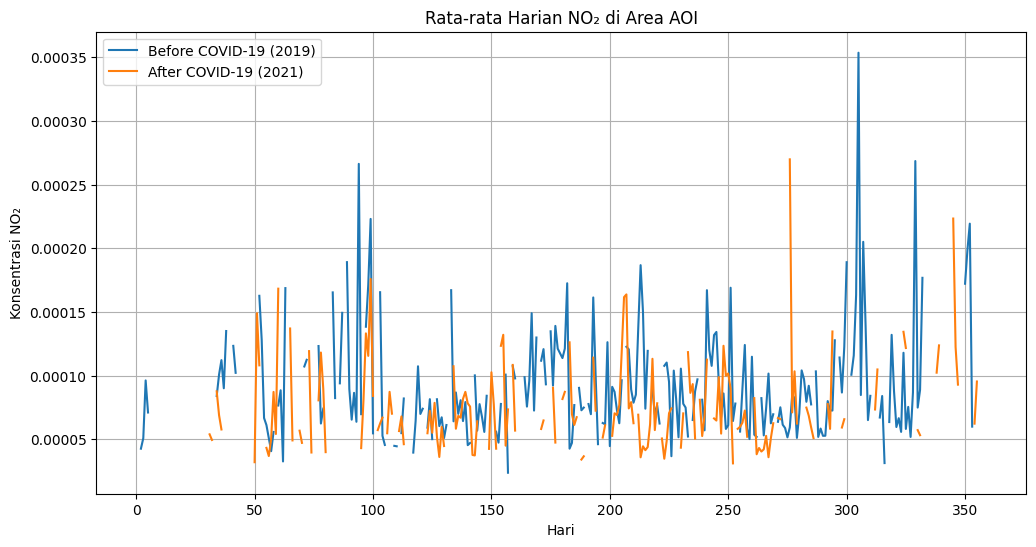

In [18]:

plt.figure(figsize=(12,6))
plt.plot(before_df["value"], label="Before COVID-19 (2019)")
plt.plot(after_df["value"], label="After COVID-19 (2021)")
plt.title("Rata-rata Harian NO₂ di Area AOI")
plt.xlabel("Hari")
plt.ylabel("Konsentrasi NO₂")
plt.legend()
plt.grid()
plt.show()
    